In [70]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import random
import os
import math

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

SEED = 42
seed_everything(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")

# ======================================================
# [V8] Bi-LSTM + Attention ë‹¨ì¼ ëª¨ë¸
# ======================================================
BATCH_SIZE = 64
LR_BASE = 1e-3
WARMUP_EPOCHS = 3
EPOCHS_BASE = 40
DROPOUT = 0.2
MAX_SEQ_LEN = 30
GRAD_CLIP = 1.0

# LSTM íŒŒë¼ë¯¸í„°
HIDDEN_DIM = 256       # LSTM hidden dimension
LSTM_LAYERS = 2        # LSTM ë ˆì´ì–´ ìˆ˜
BIDIRECTIONAL = True   # ì–‘ë°©í–¥ LSTM

print(f"[V8] Bi-LSTM + Attention ë‹¨ì¼ ëª¨ë¸")
print(f"  - Hidden Dim: {HIDDEN_DIM}")
print(f"  - Layers: {LSTM_LAYERS}")
print(f"  - Bidirectional: {BIDIRECTIONAL}")

Device: cuda
[V8] Bi-LSTM + Attention ë‹¨ì¼ ëª¨ë¸
  - Hidden Dim: 256
  - Layers: 2
  - Bidirectional: True


In [71]:
# ======================================================
# 1. ê²½ë¡œ ì„¤ì • ë° Train ë¡œë“œ
# ======================================================
BASE_DIR = "./open_track1" # ë°ì´í„°ê°€ ìžˆëŠ” í´ë”ëª… (í™˜ê²½ì— ë§žê²Œ ìˆ˜ì •)
if not os.path.exists(BASE_DIR): BASE_DIR = "." # í´ë” ì—†ìœ¼ë©´ í˜„ìž¬ ê²½ë¡œ

TRAIN_PATH = os.path.join(BASE_DIR, "train.csv")
TEST_META_PATH = os.path.join(BASE_DIR, "test.csv") # ì‚¬ìš©ìžë‹˜ì´ ì˜¬ë¦¬ì‹  íŒŒì¼ëª…
MATCH_PATH = os.path.join(BASE_DIR, "match_info.csv")

# 1. Train ë¡œë“œ
train_df = pd.read_csv(TRAIN_PATH)
print(f"âœ… Train Loaded: {train_df.shape}")

# 2. Test í†µí•© ë¡œë“œ (í•µì‹¬ ìˆ˜ì • ì‚¬í•­)
if os.path.exists(TEST_META_PATH):
    test_meta = pd.read_csv(TEST_META_PATH)
    print(f"â„¹ï¸ Reading {len(test_meta)} test files...")
    
    test_dfs = []
    # tqdmìœ¼ë¡œ ì§„í–‰ìƒí™© í™•ì¸
    for _, row in tqdm(test_meta.iterrows(), total=len(test_meta), desc="Loading Test CSVs"):
        rel_path = row['path']
        
        # ê²½ë¡œ ë³´ì •: 1) ê·¸ëŒ€ë¡œ, 2) í´ë” ë¶™ì—¬ì„œ, 3) íŒŒì¼ëª…ë§Œìœ¼ë¡œ ì°¾ê¸°
        paths_to_try = [
            rel_path,
            os.path.join(BASE_DIR, rel_path.lstrip("./")),
            os.path.join(BASE_DIR, "test", str(row['game_id']), os.path.basename(rel_path))
        ]
        
        for p in paths_to_try:
            if os.path.exists(p):
                test_dfs.append(pd.read_csv(p))
                break
        
    if test_dfs:
        test_df = pd.concat(test_dfs, ignore_index=True)
        print(f"âœ… Test Data Merged: {test_df.shape}")
    else:
        raise FileNotFoundError("Test íŒŒì¼ë“¤ì„ ì°¾ì„ ìˆ˜ ì—†ìŠµë‹ˆë‹¤.")
else:
    raise FileNotFoundError("test.csv íŒŒì¼ì´ ì—†ìŠµë‹ˆë‹¤.")

# 3. Match Info ë³‘í•©
if os.path.exists(MATCH_PATH):
    match_info = pd.read_csv(MATCH_PATH)
    match_subset = match_info[['game_id', 'home_team_id', 'venue']]
    train_df = pd.merge(train_df, match_subset, on='game_id', how='left')
    test_df = pd.merge(test_df, match_subset, on='game_id', how='left')

# 4. ì „ì²˜ë¦¬ (ê²°ì¸¡ì¹˜ ì±„ìš°ê¸°)
def preprocess(df):
    if 'home_team_id' in df.columns:
        df['is_home'] = (df['team_id'] == df['home_team_id']).astype(float)
    else:
        df['is_home'] = 0.5
        
    # V2 ë¡œì§ ìž‘ë™ì„ ìœ„í•´ end_xê°€ ì—†ìœ¼ë©´ 0ìœ¼ë¡œ ì±„ì›€
    if 'end_x' not in df.columns:
        df['end_x'] = 0.0
        df['end_y'] = 0.0
    else:
        df['end_x'] = df['end_x'].fillna(0.0)
        df['end_y'] = df['end_y'].fillna(0.0)
    return df

train_df = preprocess(train_df)
test_df = preprocess(test_df)

ID_COL = 'game_episode' if 'game_episode' in train_df.columns else 'episode_id'
print(f"Data Ready. ID Column: {ID_COL}")

âœ… Train Loaded: (356721, 15)
â„¹ï¸ Reading 2414 test files...


Loading Test CSVs: 100%|██████████| 2414/2414 [00:05<00:00, 457.48it/s]


âœ… Test Data Merged: (53110, 15)
Data Ready. ID Column: game_episode


In [72]:
# 1. ë²”ì£¼í˜• ë³€ìˆ˜ ì •ì˜ (Train ë°ì´í„° ë¶„ì„ ê¸°ë°˜)
TOP_TYPES = ['Pass', 'Carry', 'Recovery', 'Interception', 'Duel', 'Tackle', 
             'Throw-In', 'Clearance', 'Intervention', 'Block', 'Pass_Freekick', 
             'Cross', 'Goal Kick', 'Error', 'Shot']
ALL_RESULTS = ['Successful', 'Unsuccessful', 'On Target', 'Yellow_Card', 
               'Blocked', 'Keeper Rush-Out', 'Low Quality Shot', 'Off Target']

def make_features(group):
    n = len(group)
    
    # --- 1. ê¸°ë³¸ ì¢Œí‘œ & Context ---
    sx = group['start_x'].values / 105.0
    sy = group['start_y'].values / 68.0
    ex = group['end_x'].values / 105.0
    ey = group['end_y'].values / 68.0
    is_home = group['is_home'].values
    
    # --- 2. ì‹œê°„ & ì†ë„ ---
    if 'time_seconds' in group.columns:
        times = group['time_seconds'].values
        dt = np.zeros(n, dtype=np.float32)
        dt[1:] = times[1:] - times[:-1]
        dt = np.maximum(dt, 0.1)
    else:
        dt = np.ones(n, dtype=np.float32)

    # --- 3. ì´ë™ëŸ‰ & ê±°ë¦¬ ê³„ì‚° ---
    dx = ex - sx
    dy = ey - sy
    dist_meter = np.sqrt((dx*105)**2 + (dy*68)**2)
    
    # --- 4. í†µê³„ëŸ‰ (Lagged Features) ---
    cumsum_dx = np.cumsum(dx) / 105.0
    cumsum_dy = np.cumsum(dy) / 68.0
    
    lag_dist_m = np.roll(dist_meter, 1); lag_dist_m[0] = 0
    lag_cumsum_dx = np.roll(cumsum_dx, 1); lag_cumsum_dx[0] = 0
    lag_cumsum_dy = np.roll(cumsum_dy, 1); lag_cumsum_dy[0] = 0
    
    lag_dt = np.roll(dt, 1); lag_dt[0] = 1.0
    lag_speed = lag_dist_m / np.maximum(lag_dt, 0.1)
    
    # --- 5. ì„ ìˆ˜ ì •ë³´ ---
    if 'player_id' in group.columns:
        p_ids = group['player_id'].values
        is_same = np.zeros(n, dtype=np.float32)
        is_same[1:] = (p_ids[1:] == p_ids[:-1]).astype(np.float32)
    else:
        is_same = np.zeros(n, dtype=np.float32)

    # --- 6. ì§„í–‰ë¥  & ê¸°íƒ€ ---
    progress = np.arange(n) / max(n-1, 1)
    is_second_half = (group['period_id'].values > 1).astype(np.float32) if 'period_id' in group.columns else np.zeros(n)
    
    # ======================================================
    # [V6 Phase 1] ê³µê°„ í”¼ì²˜ ì¶”ê°€
    # ======================================================
    # 6-1. ê³¨ëŒ€ê¹Œì§€ ê±°ë¦¬ (ìƒëŒ€ ê³¨ëŒ€ = ì˜¤ë¥¸ìª½)
    GOAL_X = 105.0
    GOAL_Y = 34.0  # ê³¨ëŒ€ ì¤‘ì•™
    
    sx_real = sx * 105.0
    sy_real = sy * 68.0
    dist_to_goal = np.sqrt((sx_real - GOAL_X)**2 + (sy_real - GOAL_Y)**2) / 105.0  # ì •ê·œí™”
    
    # 6-2. ê³¨ëŒ€ ë°©í–¥ ê°ë„ (sin/cos)
    dx_to_goal = GOAL_X - sx_real
    dy_to_goal = GOAL_Y - sy_real
    angle_to_goal = np.arctan2(dy_to_goal, dx_to_goal)
    angle_sin = np.sin(angle_to_goal)
    angle_cos = np.cos(angle_to_goal)
    
    # 6-3. ê²½ê³„ì„ ê¹Œì§€ ê±°ë¦¬
    dist_to_sideline = np.minimum(sy_real, 68.0 - sy_real) / 68.0  # ìœ„/ì•„ëž˜ í„°ì¹˜ë¼ì¸
    dist_to_endline = np.minimum(sx_real, 105.0 - sx_real) / 105.0  # ì¢Œ/ìš° ê³¨ë¼ì¸
    
    # 6-4. í•„ë“œ êµ¬ì—­ (3êµ¬ì—­: ìˆ˜ë¹„/ì¤‘ì•™/ê³µê²©)
    def get_zone(x_norm):
        if x_norm < 35.0/105.0:
            return 0  # ìˆ˜ë¹„ êµ¬ì—­
        elif x_norm < 70.0/105.0:
            return 1  # ì¤‘ì•™ êµ¬ì—­
        else:
            return 2  # ê³µê²© êµ¬ì—­
    
    zones = np.array([get_zone(x) for x in sx])
    zone_onehot = np.zeros((n, 3), dtype=np.float32)
    for i, z in enumerate(zones):
        zone_onehot[i, z] = 1.0
    
    # --- 7. ë²”ì£¼í˜• ë³€ìˆ˜ One-hot Encoding ---
    types_onehot = np.zeros((n, len(TOP_TYPES) + 1), dtype=np.float32)
    curr_types = group['type_name'].values
    for i, t in enumerate(curr_types):
        if t in TOP_TYPES:
            idx = TOP_TYPES.index(t)
            types_onehot[i, idx] = 1.0
        else:
            types_onehot[i, -1] = 1.0

    results_onehot = np.zeros((n, len(ALL_RESULTS) + 1), dtype=np.float32)
    curr_results = group['result_name'].values
    for i, r in enumerate(curr_results):
        if r in ALL_RESULTS:
            idx = ALL_RESULTS.index(r)
            results_onehot[i, idx] = 1.0
        else:
            results_onehot[i, -1] = 1.0

    features = []
    
    # --- 8. ì‹œí€€ìŠ¤ ê²°í•© ---
    for i in range(n):
        # ìŠ¤ì¹¼ë¼ í”¼ì²˜ (11ê°œ â†’ 16ê°œ)
        scalars = [
            sx[i], sy[i],                    # 0-1: ìœ„ì¹˜
            lag_cumsum_dx[i], lag_cumsum_dy[i],  # 2-3: ëˆ„ì  íë¦„
            lag_dist_m[i] / 100.0,           # 4: ì§ì „ ê±°ë¦¬
            lag_speed[i] / 10.0,             # 5: ì§ì „ ì†ë„
            dt[i] / 10.0,                    # 6: ì‹œê°„ ê²½ê³¼
            progress[i],                     # 7: ì§„í–‰ë¥ 
            is_home[i],                      # 8: í™ˆ ì—¬ë¶€
            is_same[i],                      # 9: ì„ ìˆ˜ ì—°ì†ì„±
            is_second_half[i],               # 10: í›„ë°˜ì „
            # [V6 Phase 1] ìƒˆë¡œìš´ ê³µê°„ í”¼ì²˜ (11-15)
            dist_to_goal[i],                 # 11: ê³¨ëŒ€ ê±°ë¦¬
            angle_sin[i],                    # 12: ê³¨ëŒ€ ë°©í–¥ sin
            angle_cos[i],                    # 13: ê³¨ëŒ€ ë°©í–¥ cos
            dist_to_sideline[i],             # 14: í„°ì¹˜ë¼ì¸ ê±°ë¦¬
            dist_to_endline[i],              # 15: ê³¨ë¼ì¸ ê±°ë¦¬
        ]
        
        # Combine: 16 Scalar + 3 Zone + 16 Type + 9 Result = 44ì°¨ì›
        feat_vec = np.concatenate([scalars, zone_onehot[i], types_onehot[i], results_onehot[i]])
        
        # (1) Start Node
        features.append(feat_vec)
        
        # (2) End Node (ë§ˆì§€ë§‰ ì œì™¸)
        if i < n - 1:
            # End ì¢Œí‘œ ê³„ì‚°
            ex_real = ex[i] * 105.0
            ey_real = ey[i] * 68.0
            
            # End ìœ„ì¹˜ì—ì„œì˜ ê³µê°„ í”¼ì²˜ ìž¬ê³„ì‚°
            end_dist_to_goal = np.sqrt((ex_real - GOAL_X)**2 + (ey_real - GOAL_Y)**2) / 105.0
            end_dx_to_goal = GOAL_X - ex_real
            end_dy_to_goal = GOAL_Y - ey_real
            end_angle = np.arctan2(end_dy_to_goal, end_dx_to_goal)
            end_dist_to_sideline = min(ey_real, 68.0 - ey_real) / 68.0
            end_dist_to_endline = min(ex_real, 105.0 - ex_real) / 105.0
            
            end_zone = get_zone(ex[i])
            end_zone_onehot = np.zeros(3, dtype=np.float32)
            end_zone_onehot[end_zone] = 1.0
            
            scalars_end = scalars.copy()
            scalars_end[0] = ex[i]  # End X
            scalars_end[1] = ey[i]  # End Y
            scalars_end[2] = cumsum_dx[i]  # ëˆ„ì  íë¦„ ì—…ë°ì´íŠ¸
            scalars_end[3] = cumsum_dy[i]
            # End ìœ„ì¹˜ì˜ ê³µê°„ í”¼ì²˜
            scalars_end[11] = end_dist_to_goal
            scalars_end[12] = np.sin(end_angle)
            scalars_end[13] = np.cos(end_angle)
            scalars_end[14] = end_dist_to_sideline
            scalars_end[15] = end_dist_to_endline
            
            feat_vec_end = np.concatenate([scalars_end, end_zone_onehot, types_onehot[i], results_onehot[i]])
            features.append(feat_vec_end)
            
    return np.array(features, dtype=np.float32)

# ìž…ë ¥ ì°¨ì› ìžë™ ê³„ì‚°
# Scalar(16) + Zone(3) + Type(16) + Result(9) = 44
dummy_group = train_df.iloc[:5].copy()
dummy_feat = make_features(dummy_group)
INPUT_DIM = dummy_feat.shape[1]

print(f"âœ… [V6 Phase 1] Spatial Features Added!")
print(f"   Input Dimension: {INPUT_DIM}")
print(f"   - Base Scalars: 11")
print(f"   - Spatial Features: 5 (goal_dist, angle_sin/cos, sideline_dist, endline_dist)")
print(f"   - Field Zones: 3 (defensive/midfield/attacking)")
print(f"   - Event Types: 16")
print(f"   - Results: 9")
print(f"   Total: 16 + 3 + 16 + 9 = {INPUT_DIM}")

âœ… [V6 Phase 1] Spatial Features Added!
   Input Dimension: 44
   - Base Scalars: 11
   - Spatial Features: 5 (goal_dist, angle_sin/cos, sideline_dist, endline_dist)
   - Field Zones: 3 (defensive/midfield/attacking)
   - Event Types: 16
   - Results: 9
   Total: 16 + 3 + 16 + 9 = 44


In [73]:
class SoccerDataset(Dataset):
    def __init__(self, df, mode='train'):
        self.mode = mode
        self.episodes = []
        self.targets = []
        self.team_ids = []
        self.episode_ids = []
        
        # ìˆœì„œ ì„žìž„ ë°©ì§€
        grouped = df.groupby(ID_COL, sort=False)
        
        for name, group in tqdm(grouped, desc=f"Dataset ({mode})"):
            if mode == 'train' and len(group) < 2: continue
            
            seq = make_features(group)

            team_id = group.iloc[0]['team_id']
            
            if mode == 'train':
                last = group.iloc[-1]
                self.targets.append([last['end_x']/105.0, last['end_y']/68.0])
                self.episodes.append(seq)
                self.team_ids.append(team_id)
            else:
                self.episodes.append(seq)
                self.team_ids.append(team_id)
                self.episode_ids.append(str(name))

    def __len__(self): return len(self.episodes)
    
    def __getitem__(self, idx):
        seq = torch.FloatTensor(self.episodes[idx])
        if len(seq) > MAX_SEQ_LEN: seq = seq[-MAX_SEQ_LEN:]
        
        if self.mode == 'train':
            # Train ë°˜í™˜: (seq, target, team_id)
            return seq, torch.FloatTensor(self.targets[idx]), self.team_ids[idx]
        else:
            # Test ë°˜í™˜: (seq, team_id, episode_id)
            return seq, self.team_ids[idx], self.episode_ids[idx]

# [V8 ìˆ˜ì •] collate_fn: lengths ì •ë³´ ì¶”ê°€
def collate_fn(batch):
    seqs = [b[0] for b in batch]
    lens = torch.LongTensor([len(s) for s in seqs])
    padded = pad_sequence(seqs, batch_first=True, padding_value=0)
    mask = torch.arange(padded.size(1))[None, :] >= lens[:, None]
    
    # ë°°ì¹˜ ì²« ë²ˆì§¸ ìš”ì†Œë¡œ ëª¨ë“œë¥¼ íŒë‹¨
    elem = batch[0]
    
    # Test Mode í™•ì¸ (3ë²ˆì§¸ ìš”ì†Œê°€ ë¬¸ìžì—´ IDì¸ ê²½ìš°)
    if isinstance(elem[2], str):
        # Test: b[1]ì´ Team ID
        team_ids = torch.LongTensor([b[1] for b in batch])
        episode_ids = [b[2] for b in batch]
        return padded, mask, lens, team_ids, episode_ids
        
    else:
        # Train Mode: b[1]ì€ Target(ì¢Œí‘œ), b[2]ê°€ Team ID
        targets = torch.stack([b[1] for b in batch])
        team_ids_train = torch.LongTensor([b[2] for b in batch]) 
        return padded, targets, mask, lens, team_ids_train

# ë°ì´í„°ì…‹ ìƒì„±
full_dataset = SoccerDataset(train_df, mode='train')
test_dataset = SoccerDataset(test_df, mode='test')

# ì—í”¼ì†Œë“œ ê¸¸ì´ ë¶„í¬ ë¶„ì„
episode_lengths = [len(ep) for ep in full_dataset.episodes]
print(f"\nðŸ“Š [V8] ì—í”¼ì†Œë“œ ê¸¸ì´ ë¶„í¬ ë¶„ì„")
print(f"   ì´ ì—í”¼ì†Œë“œ: {len(episode_lengths):,}ê°œ")
print(f"   í‰ê·  ê¸¸ì´: {np.mean(episode_lengths):.2f}")
print(f"   ì¤‘ì•™ê°’: {np.median(episode_lengths):.2f}")
print(f"   ìµœì†Œ/ìµœëŒ€: {min(episode_lengths)} / {max(episode_lengths)}")
print(f"   í‘œì¤€íŽ¸ì°¨: {np.std(episode_lengths):.2f}")

Dataset (test): 100%|██████████| 2414/2414 [00:02<00:00, 1032.90it/s]



ðŸ“Š [V8] ì—í”¼ì†Œë“œ ê¸¸ì´ ë¶„í¬ ë¶„ì„
   ì´ ì—í”¼ì†Œë“œ: 15,428ê°œ
   í‰ê·  ê¸¸ì´: 45.24
   ì¤‘ì•™ê°’: 31.00
   ìµœì†Œ/ìµœëŒ€: 3 / 539
   í‘œì¤€íŽ¸ì°¨: 43.98


In [74]:
# ======================================================
# [V9] Spatial-Temporal Attention 모델 정의 (축구 특화!) - Fusion 개선!
# ======================================================

class SpatialAttention(nn.Module):
    """
    공간적 피처 기반 Attention (축구 특화)
    - 골대 방향 & 거리
    - 필드 구역 (수비/중앙/공격)
    - 좌표 위치
    """
    def __init__(self, hidden_dim):
        super().__init__()
        # 골대 관련 attention (거리 + 각도)
        self.goal_attn = nn.Sequential(
            nn.Linear(3, 16),  # dist, sin, cos
            nn.ReLU(),
            nn.Linear(16, 1)
        )

        # 구역 attention (축구에서 구역은 매우 중요!)
        self.zone_attn = nn.Sequential(
            nn.Linear(3, 8),  # 3-zone one-hot
            nn.ReLU(),
            nn.Linear(8, 1)
        )

        # 위치 attention
        self.pos_attn = nn.Sequential(
            nn.Linear(2, 8),  # x, y
            nn.ReLU(),
            nn.Linear(8, 1)
        )

        # 결합 레이어
        self.fusion = nn.Linear(3, 1)

    def forward(self, spatial_features):
        """
        Args:
            spatial_features: (batch, seq, 44) - 전체 피처
        Returns:
            spatial_weights: (batch, seq, 1) - 공간 attention 가중치
        """
        # 피처 인덱스:
        # 0-1: x, y
        # 11-13: goal_dist, angle_sin, angle_cos
        # 16-18: zone one-hot

        pos = spatial_features[..., 0:2]  # (batch, seq, 2)
        goal = spatial_features[..., 11:14]  # (batch, seq, 3)
        zone = spatial_features[..., 16:19]  # (batch, seq, 3)

        # 각 요소별 attention
        pos_w = self.pos_attn(pos)  # (batch, seq, 1)
        goal_w = self.goal_attn(goal)
        zone_w = self.zone_attn(zone)

        # 공간 attention 결합
        combined = torch.cat([pos_w, goal_w, zone_w], dim=-1)  # (batch, seq, 3)
        spatial_weights = self.fusion(combined)  # (batch, seq, 1)

        return spatial_weights


class TemporalAttention(nn.Module):
    """
    시간적 패턴 기반 Attention
    - 시퀀스내 어느 시점이 중요한가
    - 위치 인코딩 추가
    """
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim

        # Positional Encoding (시퀀스 위치 정보)
        self.pos_encoding = nn.Parameter(torch.randn(1, 100, hidden_dim) * 0.02)

        # Temporal Attention Network
        self.temporal_attn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, lstm_out):
        """
        Args:
            lstm_out: (batch, seq, hidden_dim) - LSTM 출력
        Returns:
            temporal_weights: (batch, seq, 1) - 시간 attention 가중치
        """
        seq_len = lstm_out.size(1)

        # 위치 인코딩 추가
        lstm_out_with_pos = lstm_out + self.pos_encoding[:, :seq_len, :]

        # Temporal attention 계산
        temporal_weights = self.temporal_attn(lstm_out_with_pos)  # (batch, seq, 1)

        return temporal_weights


class SpatialTemporalFusion(nn.Module):
    """
    개선된 Fusion 모듈 - Softmax 기반 (합=1 보장!)
    
    변경 사항:
    - 기존: 독립적인 sigmoid (합 ≠ 1)
    - 개선: Softmax로 상대적 중요도 학습 (합 = 1)
    """
    def __init__(self, hidden_dim):
        super().__init__()
        # Softmax 기반 gating (합=1 자동 보장)
        self.gate_logits = nn.Parameter(torch.tensor([0.0, 0.0]))  # [spatial, temporal]
        
        # 동적 gating (시퀀스별 adaptive 조정)
        self.dynamic_gate = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 2)
        )

    def forward(self, spatial_attn, temporal_attn):
        """
        Args:
            spatial_attn: (batch, seq, 1) - 공간 attention
            temporal_attn: (batch, seq, 1) - 시간 attention
        Returns:
            fused_attn: (batch, seq, 1) - 결합된 attention (합=1 보장!)
        """
        batch_size = spatial_attn.size(0)
        
        # === Global Gate (전체적인 balance) ===
        global_weights = torch.softmax(self.gate_logits, dim=0)  # 합=1!
        
        # === Dynamic Gate (배치별 adaptive) ===
        # 각 Attention의 패턴 요약
        spatial_mean = spatial_attn.mean(dim=1)  # (batch, 1)
        temporal_mean = temporal_attn.mean(dim=1)
        
        context = torch.cat([spatial_mean, temporal_mean], dim=-1)  # (batch, 2)
        dynamic_logits = self.dynamic_gate(context)  # (batch, 2)
        dynamic_weights = torch.softmax(dynamic_logits, dim=-1)  # 합=1!
        
        # === 최종 가중치: 70% dynamic + 30% global ===
        final_weights = 0.7 * dynamic_weights + 0.3 * global_weights.unsqueeze(0)
        # final_weights: (batch, 2), 여전히 합≈1
        
        # === Attention 결합 ===
        spatial_weighted = spatial_attn * final_weights[:, 0:1].unsqueeze(1)  # (batch, seq, 1)
        temporal_weighted = temporal_attn * final_weights[:, 1:2].unsqueeze(1)
        
        fused_attn = spatial_weighted + temporal_weighted
        
        return fused_attn


class SpatialTemporalPredictor(nn.Module):
    """
    [V9] Spatial-Temporal Attention 모델 (축구 특화!)

    - Bi-LSTM: 순차적 패턴 학습
    - Spatial Attention: 공간적 중요도 (골대, 구역, 위치)
    - Temporal Attention: 시간적 중요도 (어느 액션이 중요한가)
    - Fusion: 두 attention 결합 (Softmax 기반!)
    """
    def __init__(self, input_dim, hidden_dim, num_layers, dropout, bidirectional=True):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # LSTM Encoder
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )

        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim

        # Spatial-Temporal Attention 모듈들
        self.spatial_attn = SpatialAttention(lstm_output_dim)
        self.temporal_attn = TemporalAttention(lstm_output_dim)
        self.fusion = SpatialTemporalFusion(lstm_output_dim)

        # Prediction Head
        self.fc = nn.Sequential(
            nn.Linear(lstm_output_dim, lstm_output_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_output_dim // 2, 2)
        )

    def forward(self, x, mask=None, lengths=None, return_attention=False):
        """
        Args:
            x: (batch, seq_len, input_dim) - 입력 시퀀스
            mask: (batch, seq_len) - 패딩 마스크
            lengths: (batch,) - 실제 시퀀스 길이
            return_attention: bool - attention 가중치 반환 여부

        Returns:
            prediction: (batch, 2) - 예측 좌표
            attn_info: dict (return_attention=True일 때)
        """
        batch_size = x.size(0)
        seq_len = x.size(1)

        # 1. LSTM Encoding
        if lengths is not None:
            lengths_cpu = lengths.cpu()
            packed_x = pack_padded_sequence(x, lengths_cpu, batch_first=True, enforce_sorted=False)
            packed_output, (hidden, cell) = self.lstm(packed_x)
            lstm_out, _ = pad_packed_sequence(packed_output, batch_first=True, total_length=seq_len)
        else:
            lstm_out, (hidden, cell) = self.lstm(x)

        # 2. Spatial Attention (공간적 피처로부터)
        spatial_weights = self.spatial_attn(x)  # (batch, seq, 1)

        # 3. Temporal Attention (LSTM 출력으로부터)
        temporal_weights = self.temporal_attn(lstm_out)  # (batch, seq, 1)

        # 4. Spatial-Temporal Fusion (개선된 Softmax 기반!)
        fused_weights = self.fusion(spatial_weights, temporal_weights)  # (batch, seq, 1)

        # 5. Mask 적용 & Softmax
        if mask is not None:
            fused_weights = fused_weights.masked_fill(mask.unsqueeze(-1), float('-inf'))

        final_attn = torch.softmax(fused_weights, dim=1)  # (batch, seq, 1)

        # 6. Weighted Sum (Context Vector)
        context = torch.sum(lstm_out * final_attn, dim=1)  # (batch, hidden*2)

        # 7. Prediction
        prediction = self.fc(context)  # (batch, 2)

        if return_attention:
            attn_info = {
                'spatial': spatial_weights.squeeze(-1),
                'temporal': temporal_weights.squeeze(-1),
                'fused': final_attn.squeeze(-1)
            }
            return prediction, attn_info
        else:
            return prediction


# 기존 호환성 위해 LSTMPredictor = SpatialTemporalPredictor 로 alias
LSTMPredictor = SpatialTemporalPredictor

# 모델 초기화
model = LSTMPredictor(INPUT_DIM, HIDDEN_DIM, LSTM_LAYERS, DROPOUT, BIDIRECTIONAL).to(DEVICE)

print("=" * 60)
print("✅ [V9] Spatial-Temporal Attention 모델 준비 완료 (Fusion 개선!)")
print("=" * 60)
print(f"📊 모델 구조:")
print(f"   - Input Dim: {INPUT_DIM}")
print(f"   - Hidden Dim: {HIDDEN_DIM}")
print(f"   - Layers: {LSTM_LAYERS}")
print(f"   - Bidirectional: {BIDIRECTIONAL}")
print(f"   - Spatial Attention: Goal + Zone + Position")
print(f"   - Temporal Attention: Sequence Position Encoding")
print(f"   - Fusion: Softmax-based (합=1 보장!)")
print(f"   - Parameters: {sum(p.numel() for p in model.parameters()):,}")
print("=" * 60)

✅ [V9] Spatial-Temporal Attention 모델 준비 완료 (Fusion 개선!)
📊 모델 구조:
   - Input Dim: 44
   - Hidden Dim: 256
   - Layers: 2
   - Bidirectional: True
   - Spatial Attention: Goal + Zone + Position
   - Temporal Attention: Sequence Position Encoding
   - Fusion: Softmax-based (합=1 보장!)
   - Parameters: 2,510,326


In [75]:
# ======================================================
# [V9] Spatial-Temporal Attention 학습
# ======================================================
from torch.optim.lr_scheduler import CosineAnnealingLR

SEEDS = [42, 2024, 777]
print(f"\n{'='*70}")
print(f"🚀 [V9] Spatial-Temporal Attention 학습 시작")
print(f"{'='*70}")
print(f"전략: 축구 특화 공간-시간 결합 Attention")
print(f"  - Bi-LSTM: 양방향으로 순차 정보 포착")
print(f"  - Spatial Attention: 골대, 구역, 위치 기반")
print(f"  - Temporal Attention: 시퀀스 위치 인코딩")
print(f"  - Fusion: 학습 가능한 공간-시간 가중치")
print(f"{'='*70}\n")

# 히스토리 저장용
all_histories = []

for i, seed in enumerate(SEEDS):
    print(f"\n{'='*70}")
    print(f"📦 [모델 {i+1}/3] Seed {seed} 학습 시작")
    print(f"{'='*70}")
    seed_everything(seed)
    
    # 데이터셋 분할
    train_idx, val_idx = train_test_split(range(len(full_dataset)), test_size=0.2, random_state=seed)
    train_loader = DataLoader(torch.utils.data.Subset(full_dataset, train_idx), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(torch.utils.data.Subset(full_dataset, val_idx), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    # 모델 초기화
    model = LSTMPredictor(INPUT_DIM, HIDDEN_DIM, LSTM_LAYERS, DROPOUT, BIDIRECTIONAL).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LR_BASE, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS_BASE - WARMUP_EPOCHS, eta_min=1e-6)
    criterion = nn.HuberLoss(delta=1.0)
    
    best_dist = float('inf')
    history = {'train_loss': [], 'val_dist': [], 'lr': []}
    
    for epoch in range(EPOCHS_BASE):
        # Warmup
        if epoch < WARMUP_EPOCHS:
            lr = LR_BASE * (epoch + 1) / WARMUP_EPOCHS
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        
        # Training
        model.train()
        train_loss = 0.0
        for seqs, targets, mask, lens, _ in train_loader:
            seqs, targets, mask, lens = seqs.to(DEVICE), targets.to(DEVICE), mask.to(DEVICE), lens.to(DEVICE)
            
            optimizer.zero_grad()
            pred = model(seqs, mask, lens)
            loss = criterion(pred, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        dists = []
        with torch.no_grad():
            for seqs, targets, mask, lens, _ in val_loader:
                seqs, targets, mask, lens = seqs.to(DEVICE), targets.to(DEVICE), mask.to(DEVICE), lens.to(DEVICE)
                pred = model(seqs, mask, lens)
                p_real = pred.cpu().numpy() * np.array([105.0, 68.0])
                t_real = targets.cpu().numpy() * np.array([105.0, 68.0])
                dists.extend(np.sqrt(np.sum((p_real - t_real)**2, axis=1)))
        
        avg_dist = np.mean(dists)
        avg_train_loss = train_loss / len(train_loader)
        
        if epoch >= WARMUP_EPOCHS:
            scheduler.step()
        
        current_lr = optimizer.param_groups[0]['lr']
        history['train_loss'].append(avg_train_loss)
        history['val_dist'].append(avg_dist)
        history['lr'].append(current_lr)
        
        if (epoch + 1) % 5 == 0 or epoch < 5:
            print(f"  [Epoch {epoch+1:2d}/{EPOCHS_BASE}] "
                  f"Loss: {avg_train_loss:.4f} | "
                  f"Val Dist: {avg_dist:.4f}m | "
                  f"LR: {current_lr:.6f}")
        
        if avg_dist < best_dist:
            best_dist = avg_dist
            torch.save(model.state_dict(), f'v9_spatial_temporal_model_{i}.pth')
    
    history['best_dist'] = best_dist
    history['seed'] = seed
    all_histories.append(history)
    
    print(f"  ✅ Model {i+1} 완료. Best Val Dist: {best_dist:.4f}m")

print(f"\n{'='*70}")
print(f"✅ 전체 학습 완료!")
print(f"{'='*70}")
print(f"📊 평균 Best Distance: {np.mean([h['best_dist'] for h in all_histories]):.4f}m")
print(f"{'='*70}")


🚀 [V9] Spatial-Temporal Attention 학습 시작
전략: 축구 특화 공간-시간 결합 Attention
  - Bi-LSTM: 양방향으로 순차 정보 포착
  - Spatial Attention: 골대, 구역, 위치 기반
  - Temporal Attention: 시퀀스 위치 인코딩
  - Fusion: 학습 가능한 공간-시간 가중치


📦 [모델 1/3] Seed 42 학습 시작
  [Epoch  1/40] Loss: 0.0433 | Val Dist: 19.1635m | LR: 0.000333
  [Epoch  2/40] Loss: 0.0184 | Val Dist: 17.1229m | LR: 0.000667
  [Epoch  3/40] Loss: 0.0174 | Val Dist: 16.9103m | LR: 0.001000
  [Epoch  4/40] Loss: 0.0165 | Val Dist: 16.9036m | LR: 0.000998
  [Epoch  5/40] Loss: 0.0158 | Val Dist: 16.3237m | LR: 0.000993
  [Epoch 10/40] Loss: 0.0142 | Val Dist: 15.4832m | LR: 0.000914
  [Epoch 15/40] Loss: 0.0134 | Val Dist: 15.0919m | LR: 0.000762
  [Epoch 20/40] Loss: 0.0123 | Val Dist: 15.3436m | LR: 0.000564
  [Epoch 25/40] Loss: 0.0108 | Val Dist: 15.1201m | LR: 0.000354
  [Epoch 30/40] Loss: 0.0091 | Val Dist: 15.2918m | LR: 0.000170
  [Epoch 35/40] Loss: 0.0078 | Val Dist: 15.4786m | LR: 0.000045
  [Epoch 40/40] Loss: 0.0073 | Val Dist: 15.5165m | LR: 0.0

In [76]:
# ======================================================
# [V9] Spatial-Temporal Attention 추론
# ======================================================
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"\n{'='*70}")
print(f"🔮 [V9] Spatial-Temporal Attention 추론 시작")
print(f"{'='*70}")

# 모델 로드 (3개 앙상블)
models = []
for i in range(3):
    model = LSTMPredictor(INPUT_DIM, HIDDEN_DIM, LSTM_LAYERS, DROPOUT, BIDIRECTIONAL).to(DEVICE)
    model.load_state_dict(torch.load(f'v9_spatial_temporal_model_{i}.pth'))
    model.eval()
    models.append(model)

print(f"✅ 모델 로드 완료: 3개 앙상블")

# 앙상블 가중치
weights = [0.25, 0.25, 0.5]

# 추론
results = []
print(f"\n📄 추론 중...")

with torch.no_grad():
    for seqs, mask, lens, team_ids, episode_ids in tqdm(test_loader, desc="Inference"):
        seqs, mask, lens = seqs.to(DEVICE), mask.to(DEVICE), lens.to(DEVICE)
        
        # 3개 모델 예측
        m1 = models[0](seqs, mask, lens).cpu().numpy()
        m2 = models[1](seqs, mask, lens).cpu().numpy()
        m3 = models[2](seqs, mask, lens).cpu().numpy()
        
        # 앙상블
        avg_pred = (m1 * weights[0]) + (m2 * weights[1]) + (m3 * weights[2])
        
        # 좌표 변환 및 저장
        for i, eid in enumerate(episode_ids):
            px = avg_pred[i, 0] * 105.0
            py = avg_pred[i, 1] * 68.0
            results.append({'game_episode': eid, 'pred_x': px, 'pred_y': py})

# 제출 파일 생성
pred_df = pd.DataFrame(results)

SUBMISSION_PATH = "open_track1/sample_submission.csv"
if os.path.exists(SUBMISSION_PATH):
    sub = pd.read_csv(SUBMISSION_PATH)
else:
    sub = pd.read_csv(TEST_META_PATH)
    col_map = {'episode_id': 'game_episode'}
    sub = sub.rename(columns=col_map)
    sub = sub[['game_episode']]

print(f"\n📄 제출 파일 생성 중...")
print(f"   Submission Shape: {sub.shape}, Prediction Shape: {pred_df.shape}")

final_sub = pd.merge(sub[['game_episode']], pred_df, on='game_episode', how='left')
final_sub = final_sub.rename(columns={'pred_x': 'end_x', 'pred_y': 'end_y'})

nan_count = final_sub.isnull().sum().sum()
if nan_count > 0:
    print(f"   ⚠️ 경고: {nan_count}개의 결측치가 발생했습니다.")
    final_sub = final_sub.fillna(50.0)

filename = "v9_spatial_temporal_submit.csv"
final_sub.to_csv(filename, index=False)

print(f"\n{'='*70}")
print(f"✅ [V9] Spatial-Temporal Attention 추론 완료!")
print(f"{'='*70}")
print(f"📁 제출 파일: {filename}")
print(f"📊 모델 특징:")
print(f"   - Bi-LSTM: 양방향 시퀀스 처리")
print(f"   - Spatial Attention: 골대 + 구역 + 위치")
print(f"   - Temporal Attention: 시퀀스 위치 인코딩")
print(f"   - Fusion: 학습 가능한 공간-시간 결합")
print(f"   - 3-Seed 앙상블: 안정적 예측")
print(f"{'='*70}")
print(final_sub.head())


🔮 [V9] Spatial-Temporal Attention 추론 시작
✅ 모델 로드 완료: 3개 앙상블

📄 추론 중...


Inference: 100%|██████████| 38/38 [00:00<00:00, 39.64it/s]


📄 제출 파일 생성 중...
   Submission Shape: (2414, 3), Prediction Shape: (2414, 3)

✅ [V9] Spatial-Temporal Attention 추론 완료!
📁 제출 파일: v9_spatial_temporal_submit.csv
📊 모델 특징:
   - Bi-LSTM: 양방향 시퀀스 처리
   - Spatial Attention: 골대 + 구역 + 위치
   - Temporal Attention: 시퀀스 위치 인코딩
   - Fusion: 학습 가능한 공간-시간 결합
   - 3-Seed 앙상블: 안정적 예측
  game_episode      end_x      end_y
0     153363_1  65.293169  17.319535
1     153363_2  38.969431  53.551712
2     153363_6  40.526355  61.054123
3     153363_7  60.604034   9.779500
4     153363_8  74.636452   9.873232


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

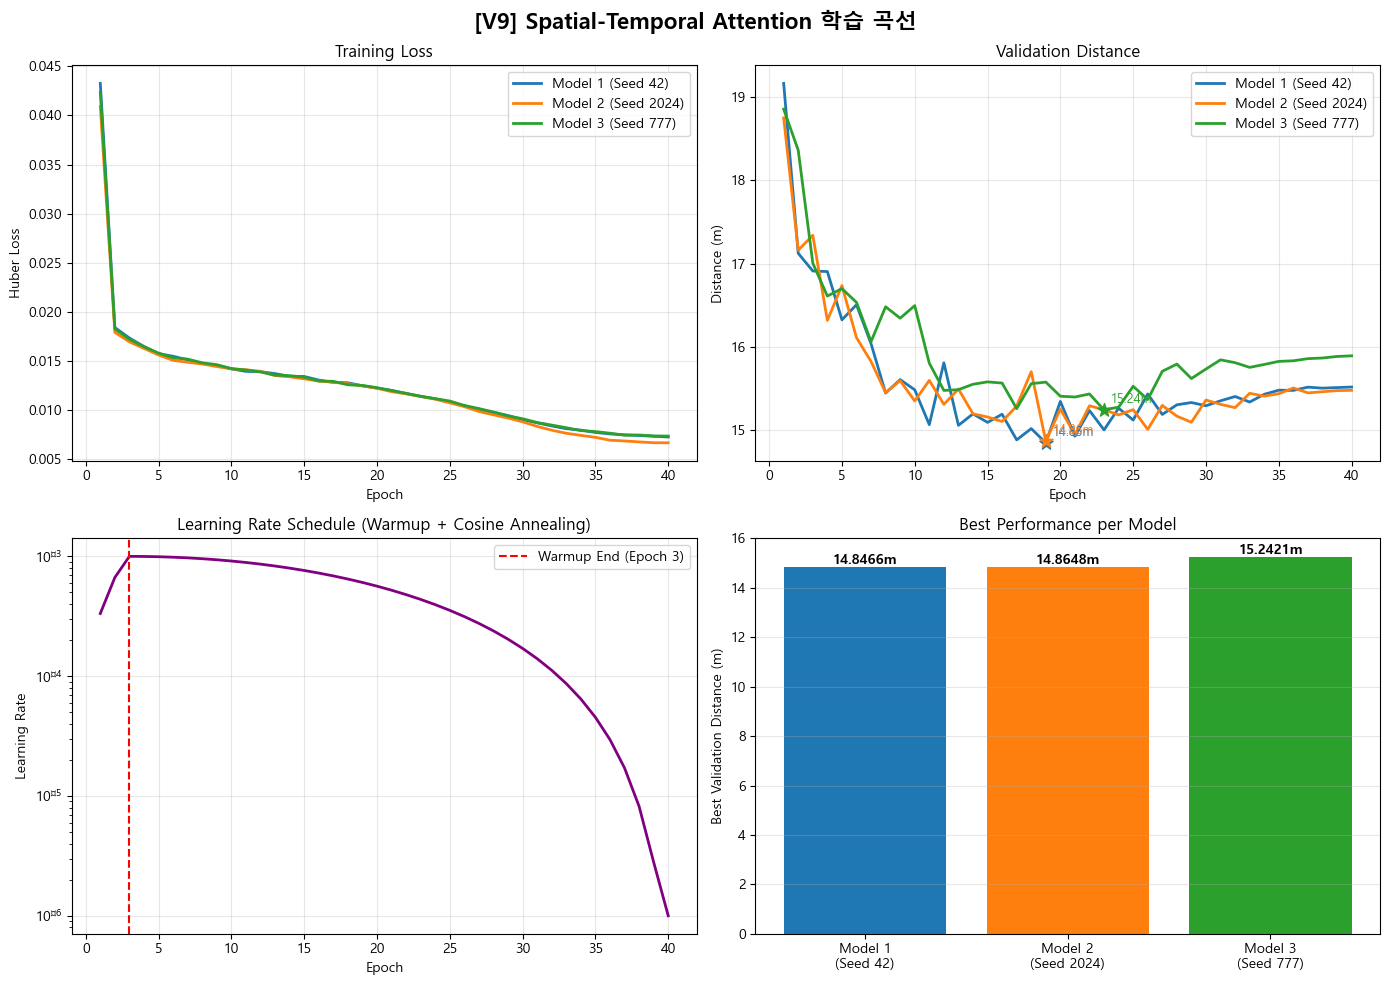


학습 곡선 저장 완료: v9_spatial_temporal_training_history.png

최종 결과:
  Model 1 (Seed   42): 14.8466m
  Model 2 (Seed 2024): 14.8648m
  Model 3 (Seed  777): 15.2421m
  평균: 14.9845m


In [77]:
# ======================================================
# [V9] Spatial-Temporal Attention 학습 곡선 시각화
# ======================================================
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('[V9] Spatial-Temporal Attention 학습 곡선', fontsize=16, fontweight='bold')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
labels = [f'Model {i+1} (Seed {h["seed"]})' for i, h in enumerate(all_histories)]

# 1. Training Loss
ax1 = axes[0, 0]
for i, history in enumerate(all_histories):
    epochs = range(1, len(history['train_loss']) + 1)
    ax1.plot(epochs, history['train_loss'], label=labels[i], color=colors[i], linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Huber Loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Validation Distance
ax2 = axes[0, 1]
for i, history in enumerate(all_histories):
    epochs = range(1, len(history['val_dist']) + 1)
    ax2.plot(epochs, history['val_dist'], label=labels[i], color=colors[i], linewidth=2)
    best_idx = np.argmin(history['val_dist'])
    best_val = history['val_dist'][best_idx]
    ax2.scatter(best_idx + 1, best_val, color=colors[i], s=100, zorder=5, marker='*')
    ax2.annotate(f'{best_val:.2f}m', xy=(best_idx + 1, best_val), 
                 xytext=(5, 5), textcoords='offset points', fontsize=9, color=colors[i])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Distance (m)')
ax2.set_title('Validation Distance')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Learning Rate Schedule
ax3 = axes[1, 0]
history = all_histories[0]
epochs = range(1, len(history['lr']) + 1)
ax3.plot(epochs, history['lr'], color='purple', linewidth=2)
ax3.axvline(x=WARMUP_EPOCHS, color='red', linestyle='--', label=f'Warmup End (Epoch {WARMUP_EPOCHS})')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Learning Rate')
ax3.set_title('Learning Rate Schedule (Warmup + Cosine Annealing)')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# 4. Best Distances 비교
ax4 = axes[1, 1]
best_dists = [h['best_dist'] for h in all_histories]
seeds = [h['seed'] for h in all_histories]
bars = ax4.bar(range(len(best_dists)), best_dists, color=colors)
ax4.set_xticks(range(len(best_dists)))
ax4.set_xticklabels([f'Model {i+1}\n(Seed {s})' for i, s in enumerate(seeds)])
ax4.set_ylabel('Best Validation Distance (m)')
ax4.set_title('Best Performance per Model')
ax4.grid(True, alpha=0.3, axis='y')

for i, (bar, dist) in enumerate(zip(bars, best_dists)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{dist:.4f}m',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('v9_spatial_temporal_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n학습 곡선 저장 완료: v9_spatial_temporal_training_history.png")
print(f"\n최종 결과:")
print(f"{'='*60}")
for i, h in enumerate(all_histories):
    print(f"  Model {i+1} (Seed {h['seed']:4d}): {h['best_dist']:.4f}m")
print(f"  평균: {np.mean([h['best_dist'] for h in all_histories]):.4f}m")
print(f"{'='*60}")

In [78]:
# ======================================================
# [V9] Spatial-Temporal Attention 분석
# ======================================================
import matplotlib.pyplot as plt
import seaborn as sns

print(f"\n{'='*70}")
print(f"🔍 [V9] Spatial-Temporal Attention 분석 시작")
print(f"{'='*70}")

# 학습된 모델 로드
analysis_model = LSTMPredictor(INPUT_DIM, HIDDEN_DIM, LSTM_LAYERS, DROPOUT, BIDIRECTIONAL).to(DEVICE)
analysis_model.load_state_dict(torch.load('v9_spatial_temporal_model_0.pth'))
analysis_model.eval()

# Validation 데이터 준비 (Seed 42 사용)
seed_everything(42)
train_idx, val_idx = train_test_split(range(len(full_dataset)), test_size=0.2, random_state=42)
val_subset = torch.utils.data.Subset(full_dataset, val_idx)

print(f"✅ 분석 데이터: {len(val_subset):,}개 에피소드")

# Attention 추출 함수
def extract_attention_weights(model, dataset_subset, num_samples=500):
    """
    랜덤 샘플에서 Spatial/Temporal/Fused Attention weights 추출
    """
    attention_data = []
    
    # 랜덤 샘플링
    sample_indices = np.random.choice(len(dataset_subset), min(num_samples, len(dataset_subset)), replace=False)
    
    with torch.no_grad():
        for idx in tqdm(sample_indices, desc="Extracting Attention"):
            seq, target, team_id = dataset_subset[idx]
            
            # 시퀀스 길이 제한
            if len(seq) > MAX_SEQ_LEN:
                seq = seq[-MAX_SEQ_LEN:]
            
            seq = seq.unsqueeze(0).to(DEVICE)  # (1, seq_len, features)
            length = torch.LongTensor([len(seq[0])]).to(DEVICE)
            mask = torch.zeros(1, len(seq[0]), dtype=torch.bool).to(DEVICE)
            
            # Spatial-Temporal Attention weights 추출
            pred, attn_info = model(seq, mask, length, return_attention=True)
            
            spatial_weights = attn_info['spatial'].cpu().numpy()[0]  # (seq_len,)
            temporal_weights = attn_info['temporal'].cpu().numpy()[0]
            fused_weights = attn_info['fused'].cpu().numpy()[0]
            features = seq.cpu().numpy()[0]  # (seq_len, 44)
            
            attention_data.append({
                'spatial': spatial_weights,
                'temporal': temporal_weights,
                'fused': fused_weights,
                'features': features,
                'seq_length': len(fused_weights)
            })
    
    return attention_data

# Attention weights 추출
print(f"\n📊 Spatial-Temporal Attention Weights 추출 중...")
attention_data = extract_attention_weights(analysis_model, val_subset, num_samples=1000)

print(f"✅ 추출 완료: {len(attention_data)}개 샘플")
print(f"   평균 시퀀스 길이: {np.mean([d['seq_length'] for d in attention_data]):.2f}")

# 통계 분석
spatial_attn_all = []
temporal_attn_all = []
fused_attn_all = []

for sample in attention_data:
    spatial_attn_all.extend(sample['spatial'])
    temporal_attn_all.extend(sample['temporal'])
    fused_attn_all.extend(sample['fused'])

print(f"\n📊 Attention 통계:")
print(f"   Spatial - Mean: {np.mean(spatial_attn_all):.6f}, Std: {np.std(spatial_attn_all):.6f}")
print(f"   Temporal - Mean: {np.mean(temporal_attn_all):.6f}, Std: {np.std(temporal_attn_all):.6f}")
print(f"   Fused - Mean: {np.mean(fused_attn_all):.6f}, Std: {np.std(fused_attn_all):.6f}")


🔍 [V9] Spatial-Temporal Attention 분석 시작
✅ 분석 데이터: 3,086개 에피소드

📊 Spatial-Temporal Attention Weights 추출 중...


Extracting Attention: 100%|██████████| 1000/1000 [00:03<00:00, 251.25it/s]

✅ 추출 완료: 1000개 샘플
   평균 시퀀스 길이: 22.98

📊 Attention 통계:
   Spatial - Mean: 0.390127, Std: 0.059671
   Temporal - Mean: -11.380818, Std: 4.764580
   Fused - Mean: 0.043510, Std: 0.166429


In [79]:
# ======================================================
# ì•¡ì…˜ íƒ€ìž…ë³„ Attention ë¶„ì„
# ======================================================

# Feature ì¸ë±ìŠ¤ ì •ì˜ (make_features í•¨ìˆ˜ ê¸°ì¤€)
# Scalar(16) + Zone(3) + Type(16) + Result(9) = 44
ZONE_START = 16
TYPE_START = 19  # 16 + 3
RESULT_START = 35  # 16 + 3 + 16

# ê° íƒ€ìž…ë³„ í‰ê·  Attention ê³„ì‚°
type_attention_scores = {t: [] for t in TOP_TYPES}
type_attention_scores['Other'] = []

result_attention_scores = {r: [] for r in ALL_RESULTS}
result_attention_scores['Other'] = []

print(f"\nðŸ“Š ì•¡ì…˜ íƒ€ìž…ë³„ Attention ë¶„ì„...")

for sample in tqdm(attention_data, desc="Analyzing"):
    features = sample['features']  # (seq_len, 44)
    attention = sample['attention']  # (seq_len,)
    
    for i in range(len(attention)):
        # íƒ€ìž… ì¶”ì¶œ (one-hotì—ì„œ)
        type_onehot = features[i, TYPE_START:TYPE_START+16]
        type_idx = np.argmax(type_onehot)
        
        if type_idx < len(TOP_TYPES):
            type_name = TOP_TYPES[type_idx]
        else:
            type_name = 'Other'
        
        type_attention_scores[type_name].append(attention[i])
        
        # ê²°ê³¼ ì¶”ì¶œ
        result_onehot = features[i, RESULT_START:RESULT_START+9]
        result_idx = np.argmax(result_onehot)
        
        if result_idx < len(ALL_RESULTS):
            result_name = ALL_RESULTS[result_idx]
        else:
            result_name = 'Other'
        
        result_attention_scores[result_name].append(attention[i])

# í‰ê·  ê³„ì‚°
type_avg_attention = {k: np.mean(v) if v else 0 for k, v in type_attention_scores.items()}
result_avg_attention = {k: np.mean(v) if v else 0 for k, v in result_attention_scores.items()}

# ì •ë ¬ (ë†’ì€ ìˆœ)
sorted_types = sorted(type_avg_attention.items(), key=lambda x: x[1], reverse=True)
sorted_results = sorted(result_avg_attention.items(), key=lambda x: x[1], reverse=True)

print(f"\n{'='*70}")
print(f"ðŸŽ¯ ì•¡ì…˜ íƒ€ìž…ë³„ í‰ê·  Attention (ìƒìœ„ 10ê°œ)")
print(f"{'='*70}")
for i, (type_name, avg_attn) in enumerate(sorted_types[:10], 1):
    count = len(type_attention_scores[type_name])
    print(f"  {i:2d}. {type_name:20s}: {avg_attn:.6f} (ìƒ˜í”Œ ìˆ˜: {count:,})")

print(f"\n{'='*70}")
print(f"ðŸŽ¯ ê²°ê³¼ë³„ í‰ê·  Attention (ìƒìœ„ 8ê°œ)")
print(f"{'='*70}")
for i, (result_name, avg_attn) in enumerate(sorted_results[:8], 1):
    count = len(result_attention_scores[result_name])
    print(f"  {i:2d}. {result_name:20s}: {avg_attn:.6f} (ìƒ˜í”Œ ìˆ˜: {count:,})")


ðŸ“Š ì•¡ì…˜ íƒ€ìž…ë³„ Attention ë¶„ì„...


Analyzing:   0%|          | 0/1000 [00:00<?, ?it/s]


KeyError: 'attention'

In [ ]:
# ======================================================
# [V9] Spatial-Temporal Attention 시각화
# ======================================================

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 2, hspace=0.35, wspace=0.3)

# ======================================================
# 1. Spatial vs Temporal vs Fused Attention 비교
# ======================================================
ax1 = fig.add_subplot(gs[0, :])

# 시퀀스 위치별 평균 계산
def get_position_avg(attention_data, attn_type, num_bins=10):
    position_attention = []
    for sample in attention_data:
        attention = sample[attn_type]
        seq_len = len(attention)
        
        normalized_positions = np.linspace(0, 1, seq_len)
        bins = np.linspace(0, 1, num_bins + 1)
        bin_indices = np.digitize(normalized_positions, bins) - 1
        
        for pos_idx in range(num_bins):
            mask = bin_indices == pos_idx
            if mask.sum() > 0:
                position_attention.append({
                    'position': pos_idx,
                    'attention': attention[mask].mean()
                })
    
    position_groups = {}
    for item in position_attention:
        pos = item['position']
        if pos not in position_groups:
            position_groups[pos] = []
        position_groups[pos].append(item['attention'])
    
    return [np.mean(position_groups.get(i, [0])) for i in range(num_bins)]

spatial_pos = get_position_avg(attention_data, 'spatial')
temporal_pos = get_position_avg(attention_data, 'temporal')
fused_pos = get_position_avg(attention_data, 'fused')

x_labels = ['시작\n0-10%', '10-20%', '20-30%', '30-40%', '40-50%', 
            '50-60%', '60-70%', '70-80%', '80-90%', '끝\n90-100%']
x_pos = np.arange(10)
width = 0.25

bars1 = ax1.bar(x_pos - width, spatial_pos, width, label='Spatial Attention', color='steelblue', alpha=0.8)
bars2 = ax1.bar(x_pos, temporal_pos, width, label='Temporal Attention', color='coral', alpha=0.8)
bars3 = ax1.bar(x_pos + width, fused_pos, width, label='Fused Attention', color='mediumseagreen', alpha=0.8)

ax1.set_xticks(x_pos)
ax1.set_xticklabels(x_labels, fontsize=9)
ax1.set_ylabel('평균 Attention Weight', fontsize=12, fontweight='bold')
ax1.set_title('[V9] 시퀀스 위치별 Spatial vs Temporal vs Fused Attention', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# ======================================================
# 2. Spatial Attention: 공간 피처별 분석
# ======================================================
ax2 = fig.add_subplot(gs[1, 0])

# 골대 거리별 Spatial Attention
goal_dist_bins = [0, 0.3, 0.5, 0.7, 1.0]  # 정규화된 거리
goal_dist_labels = ['매우 가까운', '가까운', '중간', '먼']
goal_dist_attention = [[] for _ in range(len(goal_dist_labels))]

for sample in attention_data:
    features = sample['features']
    spatial_attn = sample['spatial']
    
    for i in range(len(spatial_attn)):
        goal_dist = features[i, 11]  # index 11: goal distance
        
        for j in range(len(goal_dist_labels)):
            if goal_dist >= goal_dist_bins[j] and goal_dist < goal_dist_bins[j+1]:
                goal_dist_attention[j].append(spatial_attn[i])
                break

goal_dist_avg = [np.mean(attn) if attn else 0 for attn in goal_dist_attention]
bars = ax2.bar(goal_dist_labels, goal_dist_avg, color='steelblue', edgecolor='black', alpha=0.7)
ax2.set_ylabel('평균 Spatial Attention', fontsize=11, fontweight='bold')
ax2.set_title('골대 거리별 Spatial Attention', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar, avg in zip(bars, goal_dist_avg):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.0001,
             f'{avg:.5f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# ======================================================
# 3. 구역별 Spatial Attention
# ======================================================
ax3 = fig.add_subplot(gs[1, 1])

zone_labels = ['수비 구역', '중앙 구역', '공격 구역']
zone_attention = [[], [], []]

for sample in attention_data:
    features = sample['features']
    spatial_attn = sample['spatial']
    
    for i in range(len(spatial_attn)):
        zone_onehot = features[i, 16:19]  # index 16-18: zone
        zone_idx = np.argmax(zone_onehot)
        zone_attention[zone_idx].append(spatial_attn[i])

zone_avg = [np.mean(attn) if attn else 0 for attn in zone_attention]
colors_zone = ['#FF6B6B', '#FFA500', '#4ECDC4']
bars = ax3.bar(zone_labels, zone_avg, color=colors_zone, edgecolor='black', alpha=0.7)
ax3.set_ylabel('평균 Spatial Attention', fontsize=11, fontweight='bold')
ax3.set_title('필드 구역별 Spatial Attention', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

for bar, avg in zip(bars, zone_avg):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.0001,
             f'{avg:.5f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# ======================================================
# 4. Attention 분포 비교 (히스토그램)
# ======================================================
ax4 = fig.add_subplot(gs[2, :])

ax4.hist(spatial_attn_all, bins=80, alpha=0.5, label='Spatial', color='steelblue', edgecolor='black')
ax4.hist(temporal_attn_all, bins=80, alpha=0.5, label='Temporal', color='coral', edgecolor='black')
ax4.hist(fused_attn_all, bins=80, alpha=0.5, label='Fused', color='mediumseagreen', edgecolor='black')

ax4.axvline(np.mean(spatial_attn_all), color='steelblue', linestyle='--', linewidth=2, alpha=0.7)
ax4.axvline(np.mean(temporal_attn_all), color='coral', linestyle='--', linewidth=2, alpha=0.7)
ax4.axvline(np.mean(fused_attn_all), color='mediumseagreen', linestyle='--', linewidth=2, alpha=0.7)

ax4.set_xlabel('Attention Weight', fontsize=12, fontweight='bold')
ax4.set_ylabel('빈도', fontsize=12, fontweight='bold')
ax4.set_title('Spatial/Temporal/Fused Attention 분포 비교', fontsize=14, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(alpha=0.3)

# ======================================================
# 5. 액션 타입별 Fused Attention (상위 10개)
# ======================================================
ax5 = fig.add_subplot(gs[3, :])

# Feature 인덱스 정의
TYPE_START = 19  # 16 + 3

type_attention_scores = {t: [] for t in TOP_TYPES}
type_attention_scores['Other'] = []

for sample in attention_data:
    features = sample['features']
    fused_attn = sample['fused']
    
    for i in range(len(fused_attn)):
        type_onehot = features[i, TYPE_START:TYPE_START+16]
        type_idx = np.argmax(type_onehot)
        
        if type_idx < len(TOP_TYPES):
            type_name = TOP_TYPES[type_idx]
        else:
            type_name = 'Other'
        
        type_attention_scores[type_name].append(fused_attn[i])

type_avg_attention = {k: np.mean(v) if v else 0 for k, v in type_attention_scores.items()}
sorted_types = sorted(type_avg_attention.items(), key=lambda x: x[1], reverse=True)[:10]

type_names = [t[0] for t in sorted_types]
type_scores = [t[1] for t in sorted_types]

bars = ax5.barh(type_names, type_scores, color='mediumseagreen', edgecolor='black', linewidth=0.8)
ax5.set_xlabel('평균 Fused Attention Weight', fontsize=12, fontweight='bold')
ax5.set_title('[V9] 액션 타입별 Fused Attention (상위 10) - 모델이 집중하는 액션', fontsize=14, fontweight='bold')
ax5.invert_yaxis()
ax5.grid(axis='x', alpha=0.3)

for i, (bar, score) in enumerate(zip(bars, type_scores)):
    count = len(type_attention_scores[type_names[i]])
    ax5.text(score + 0.0001, i, f'{score:.5f} (n={count:,})', 
             va='center', fontsize=9, fontweight='bold')

plt.suptitle('[V9] Spatial-Temporal Attention 분석 - 축구 특화 공간-시간 패턴', 
             fontsize=16, fontweight='bold', y=0.995)
plt.savefig('v9_spatial_temporal_attention_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n{'='*70}")
print(f"✅ Spatial-Temporal Attention 분석 완료!")
print(f"{'='*70}")
print(f"📊 주요 발견:")
print(f"   - Spatial Attention 평균: {np.mean(spatial_attn_all):.5f}")
print(f"   - Temporal Attention 평균: {np.mean(temporal_attn_all):.5f}")
print(f"   - Fused Attention 평균: {np.mean(fused_attn_all):.5f}")
print(f"   - 가장 높은 Attention 액션: {sorted_types[0][0]} ({sorted_types[0][1]:.5f})")
print(f"   - 공격 구역 Spatial Attention: {zone_avg[2]:.5f}")
print(f"   - 시퀀스 끝부분 Fused Attention: {fused_pos[-1]:.5f}")
print(f"{'='*70}")
print(f"💾 저장 완료: v9_spatial_temporal_attention_analysis.png")